# Reto 1

## Miguel Ortiz y Andrea Castiella

In [1]:
import numpy  as np
import pandas as pd
import OurUtils as our
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler

In [2]:
FullSet_3 = pd.read_csv('./1000_tres.csv', header=None)
FullSet_7 = pd.read_csv('./1000_siete.csv', header=None)

# Scale image to range [0,1]
FullSet_3 = FullSet_3 / 255.0
FullSet_7 = FullSet_7 / 255.0

## Features

To select the features for this exercise, we take into consideration the geometric characteristics of each number.
First, the image was divided into 4 parts(upper, right, left, lower) and then we calculate the area/sum of the pixels in these parts. Then, we try to granulate more the zones that we selected before, and calculate the sum/area of a quarter of the image.

- feat_1: it represents the percent of pixels that are superior to a certain threshold in the **left** side of the image. 
- feat_2: it represents the percent of pixels that are superior to a certain threshold in the **lower** side of the image.
- feat_3: it represents the percent of pixels that are superior to a certain threshold in the **right** side of the image.
- feat_4: it represents the percent of pixels that are superior to a certain threshold in the **upper** side of the image.
- feat_5: it represents the percent of pixels that are superior to a certain threshold in the **lower-right** side of the image.
- feat_6: Max value of the column sum of the entire image
- feat_7: **width distance** of the number in the lower side of the image
- feat_8: **height distance** of the number in the lower side of the image
- feat_9: Ratio between the maximum width in the superior and lower part of the image.

In [3]:
def feat_extraction(data, perc=0.3, perc2=0.45, alfa=0.5, adjust=True):
    num_feat = 9
    features = np.zeros([data.shape[0], num_feat])
    data = data.values.reshape([data.shape[0],28,28]) # Each row is an image, reshape a 28x28.

    for i in range(data.shape[0]): # For each image.
        img = data[i,:,:]
        if adjust:
            img = our.number_adjust(img) # Returns an image with the size adjusted to the number.
        # Característica 1
        img_left = img[:, :int(img.shape[1]*(perc))]
        feat_1 = np.sum(img_left > 0.5)/(img_left.shape[0]*img_left.shape[1]) # Percentage of pixels of the left % of the image > 128 (0.5).
        features[i, 0] = feat_1
        # Característica 2
        img_inf = img[int(img.shape[0]*(1-perc)):, :]
        # feat_2 = np.sum(img_inf) # Sum of the pixels of the lower % of the image.
        feat_2 = np.sum(img_inf > 0.5)/(img_inf.shape[0]*img_inf.shape[1]) # Percentage of pixels of the lower % of the image > 128 (0.5).
        features[i, 1] = feat_2
        # Característica 3
        img_right = img[:, int(img.shape[1]*(1-perc)):]
        # feat_3 = np.sum(img_der) # Sum of the pixels of the right % of the image.
        feat_3 = np.sum(img_right > 0.5)/(img_right.shape[0]*img_right.shape[1]) # Percentage of pixels of the right % of the image > 128 (0.5).
        features[i, 2] = feat_3
        # Característica 4
        img_sup = img[:int(img.shape[0]*(perc)), :]
        # feat_4 = np.sum(img_sup) # Sum of the pixels in the upper % of the image
        feat_4 = np.sum(img_sup > 0.5)/(img_sup.shape[0]*img_sup.shape[1]) # Percentage of pixels of the upper % of the image > 128 (0.5).
        features[i, 3] = feat_4
        # Característica 5
        img_cuad = img[int(img.shape[0]*(1-perc)):,int(img.shape[1]*(perc)):]
        # feat_5 = np.sum(img_cuad) # Sum of the lower right quadrant
        feat_5 = np.sum(img_cuad > 0.5)/(img_cuad.shape[0]*img_cuad.shape[1]) # Percentage of pixels of the lower right quadrant % of the image > 128 (0.5).
        features[i, 4] = feat_5
        # Característica 6
        feat_6 = np.amax(np.sum(img, axis=0)) # Maximum value of the sum of the columns.
        features[i, 5] = feat_6
        # Característica 7
        img_inf = img[int(img.shape[0]*(1-perc)):, :] # Lower %.
        sum_cols = img_inf.sum(axis=0)
        indc = np.argwhere(sum_cols > alfa * sum_cols.max())
        feat_7 = indc[-1] - indc[0] # Theta-dependent width of the lower % of the image.
        features[i, 6] = feat_7
        # Característica 8
        img_inf = img[int(img.shape[0]*(1-perc)):, :] # Lower %.
        sum_rows = img_inf.sum(axis=1)
        indr = np.argwhere(sum_rows > alfa * sum_rows.max())
        feat_8 = indr[-1] - indr[0] # High dependent on theta of the lower % of the image.
        features[i, 7] = feat_8
        # Caracteristica 9
        img_upper = img[:int(img.shape[0] * (perc2)), :]
        sum_rows = img_upper.sum(axis = 1)
        idx_row = sum_rows.argmax()
        img_row = img_upper[idx_row, :]
        args = np.argwhere( img_row > 0.6)
        distance_upper = args[-1,0] - args[0,0]
        if distance_upper == 0:
            distance_upper = 0.01
        img_lower = img[int(img.shape[0] * (1-perc2)):, :]
        sum_rows = img_lower.sum(axis = 1)
        idx_row = sum_rows.argmax()
        img_row = img_lower[idx_row, :]
        args = np.argwhere( img_row > 0.6)
        distance_lower = args[-1,0] - args[0,0]
        features[i, 8] = float(distance_lower)/float(distance_upper) # Max upper distance / max lower distance
    col_names = ['feat_1','feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6', 'feat_7', 'feat_8', 'feat_9']
    return pd.DataFrame(features,columns = col_names)

## Feature Engineering
- Feature multiplication
- Feature division

In [4]:
# Multiplies the value of two given characteristics
def feat_mult(features, feat_name='', feat1 = 'feat_2', feat2 = 'feat-5'):
    mult = features[feat1] * features[feat2]
    return pd.DataFrame({feat_name:mult})

# Divides the value of two given characteristics
def feat_div(features, feat_name='', feat1 = 'feat_2', feat2 = 'feat-4'):
    div = features[feat1] / (features[feat2] + 0.00001)
    return pd.DataFrame({feat_name:div})

## Feature extraction
Label for number 3: 0

Label for number 7: 1

In [5]:
FullSet = our.join_features_labels(FullSet_3, FullSet_7)
seed = 1234
theta = 0.5
X_full = feat_extraction( FullSet.drop('label', axis=1))
area = feat_mult(X_full, 'area', feat1='feat_7', feat2='feat_8')
X_full = pd.concat([X_full, area],axis=1)
mult_25 = feat_mult(X_full, 'mult_25', feat1='feat_2', feat2='feat_5')
X_full = pd.concat([X_full, mult_25],axis=1)
div_24 = feat_div(X_full, 'div_24', feat1='feat_2', feat2='feat_4')
X_full = pd.concat([X_full, div_24],axis=1)
#X_full.head()
Y_full = FullSet[['label']]

## Split dataset
Train split: 1600 samples

Test split: 400 samples

In [6]:
test_size = 0.2
splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
split_ix = splitter.split(X_full,Y_full)
for train_ix, test_ix in split_ix:
    X_train = X_full.loc[train_ix].reset_index(drop=True)
    #Raranges the indexes
        #print(X_full.loc[train_ix])
        #print(X_train)
    Y_train = Y_full.loc[train_ix].reset_index(drop=True)
    X_test  = X_full.loc[test_ix].reset_index(drop=True)
    Y_test  = Y_full.loc[test_ix].reset_index(drop=True)

## Feature selection

In [7]:
# Selected features after analyzing different combinations
feats = ['feat_9', 'div_24']
scaler = MinMaxScaler()
X = scaler.fit_transform(X_train[feats])
Y = Y_train.values.ravel() # Returns data as numpy array

## Feature representation

This graph give information about how separable can be the selected features for each class

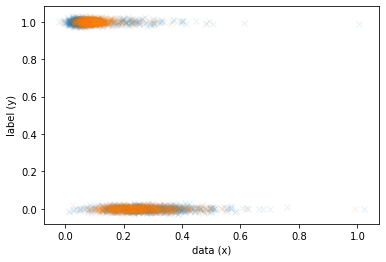

In [8]:
plt.plot(our.jitter(X,sigma=0.01), our.jitter(Y,sigma=0.01),'x',alpha=0.1)
plt.xlabel('data (x)'); plt.ylabel('label (y)')
plt.show()

## Logistic Regression
The variable ``Y_pred``is an array of shape ``[samples, 2]`` and the second dimension contains the probability for each class. Eg., [0.2, 0.8]. The label 0 correspond to 0.2 and label 1 to the latter.

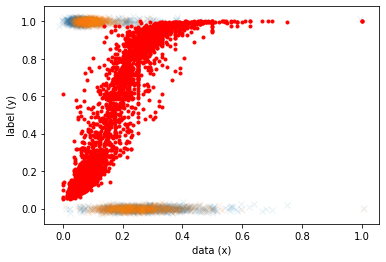

In [9]:
from sklearn.linear_model import LogisticRegression

recta_regresion = LogisticRegression()
recta_regresion.fit(X,Y)
y_CDF = recta_regresion.predict_proba(X)
y_pred = y_CDF[:,0]  # Use 0 instead of 1 to see the logistic curve of the other class

plt.plot(our.jitter(X,sigma=0.01), our.jitter(Y,sigma=0.01),'x',alpha=0.1)
plt.plot(X, y_pred, '.r')
plt.xlabel('data (x)'); plt.ylabel('label (y)')
plt.show()

## Confusion Matrix

To check the performance of our model, we use Confusion Matrix as metric. This give us a general idea of how good is the model and let us compare it with the multiple combinations of feature that we have available.

Obtained results for our best model:

|CM|Positive|Negative|
|-|-|-|
**Positive**|185|15
**Negative**|9|191

As it is observed, the model tend to fail more for the label 1, that is the representation of the number 7.
    

In [10]:
from sklearn.metrics import confusion_matrix
X_test = scaler.transform(X_test[feats])
y_test_pred = recta_regresion.predict(X_test)
conf_mat = confusion_matrix(Y_test, y_test_pred)
hits = conf_mat[0,0] + conf_mat[1,1]
fails = conf_mat[0,1] + conf_mat[1,0]
strlog = "HITS = %d, FAILS = %d" %(hits , fails )
print(strlog)

HITS = 376, FAILS = 24


## Discriminant Function

To choose the parameter that defines the discrimination function, we visualize the distribution of the data next to the logistic regression function to see which parameter value best separates the two cases.

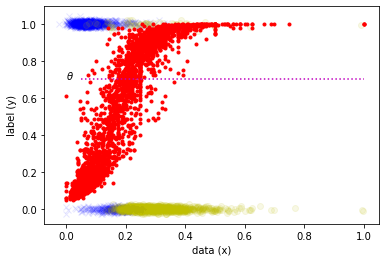

In [12]:
theta = 0.7 # Parameter defining the discrimination function.

ix_1 = y_pred < theta
ix_0 = ~ix_1
plt.plot( our.jitter(X[ix_1],sigma=0.01), \
          our.jitter(Y[ix_1],sigma=0.01), \
          'bx',alpha=0.1)
plt.plot( our.jitter(X[ix_0],sigma=0.01), \
          our.jitter(Y[ix_0],sigma=0.01), \
          'yo',alpha=0.1)
plt.text(0,theta, r'$ \theta $')
plt.plot(X,y_pred,'.r')
plt.plot([0.05,1],[theta,theta],'m:')
plt.xlabel('data (x)'); plt.ylabel('label (y)')
plt.show()

## Competition data
Using the transform method we can use the same mean and variance as it is calculated
from our training data to transform our test data (using fit_transform). Thus, the
parameters learned by our model using the training data will help us to transform our test data.

In [15]:
# Load competition data
challenge_data = pd.read_csv('./reto1_X.csv', header=None)
challenge_data = challenge_data/255.0
# Feature extraction
challenge_features = feat_extraction(challenge_data)
area = feat_mult(challenge_features, 'area', feat1='feat_7', feat2='feat_8')
challenge_features = pd.concat([challenge_features, area],axis=1)
mult_25 = feat_mult(challenge_features, 'mult_25', feat1='feat_2', feat2='feat_5')
challenge_features = pd.concat([challenge_features, mult_25],axis=1)
div_24 = feat_div(challenge_features, 'div_24', feat1='feat_2', feat2='feat_4')
challenge_features = pd.concat([challenge_features, div_24],axis=1)
challenge_features = scaler.transform(challenge_features[feats])
# Inference
y_challenge = recta_regresion.predict_proba(challenge_features)
y_challenge_pred = y_challenge[:,1]
ix_3_chall = y_challenge_pred < theta
ix_7_chall = ~ix_3_chall
print(y_challenge)
print(ix_7_chall)


[[0.07772069 0.92227931]
 [0.1177556  0.8822444 ]
 [0.18528119 0.81471881]
 ...
 [0.96633803 0.03366197]
 [0.70834529 0.29165471]
 [0.07895944 0.92104056]]
[ True  True  True ... False False  True]


## Save results

In [16]:
np.savetxt('reto1_Ypred.csv', ix_7_chall, fmt='%i', delimiter=',')

## Image visualizer

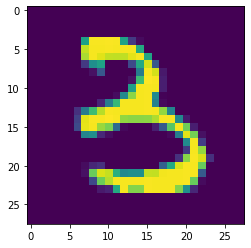

In [50]:
# '3' examples
num_3 = 78 # Image number
data_3 = FullSet_3.values.reshape([FullSet_3.shape[0],28,28])
img_3 = data_3[num_3,:,:]
plt.imshow(img_3)

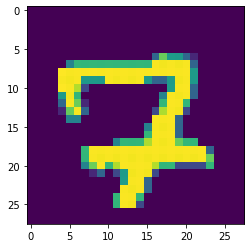

In [51]:
# '7' examples
num_7 = 78 # Image number
data_7 = FullSet_7.values.reshape([FullSet_7.shape[0],28,28])
img_7 = data_7[num_7,:,:]
plt.imshow(img_7)

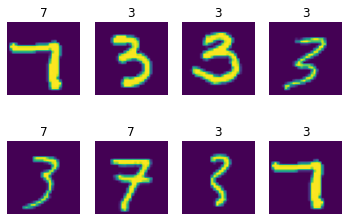

In [17]:
# Challenge images representation
from numpy.random import default_rng
numb_img = 8
rng = default_rng()
numbers = rng.choice(10000, size=numb_img, replace=False)

chall_input = pd.read_csv('./reto1_X.csv', header=None)
chall_input = chall_input / 255.0
chall_input = chall_input.values.reshape([chall_input.shape[0],28,28])

chall_results = pd.read_csv('./reto1_Ypred.csv', header=None)
chall_results = chall_results.values

images = np.zeros((numb_img,28,28))
img_labels = np.zeros((numb_img,))
for i in range(numb_img):
    images[i] = chall_input[numbers[i],:,:]
    pred = 7 if chall_results[numbers[i]] == 1 else 3
    img_labels[i] = pred


f, axarr = plt.subplots(2,4)
x, y = 0, 0
for i in range(images.shape[0]):

    img_y = img_labels[i]
    axarr[x,y].imshow(images[i])
    axarr[x,y].axis('off')
    axarr[x,y].title.set_text(str(int(img_y)))
    y = y + 1
    if y == axarr.shape[1]:
        y = 0
        x = x + 1
        
plt.imshow(images[0])